# Basics of LLM
Source: most of the code is copied or adapted from The Fuzzy Scientist's [LLMs Mastery: Complete Guide to Transformers & Generative AI](https://udemy.com/course/llms-mastery-complete-guide-to-transformers-generative-ai) course on Udemy. The course is a lot more extensive than what is presented here and should be followed to understand all the concepts and the full context.

## Tokenise, encode, decode
This first step only includes basic steps:
- prepare a tokeniser
- prepare a model (DistilBERT, a light version of BERT)
- tokenise a sentence and encode it
- decode the sentence

The objective of this cell is only to give an overview of what the different steps look like in code.

Some tokens are unique to BERT:
- `[CLS]` indicates the beginning of a new sequence, it is represented by token ID `101`
- `[SEP]` indicates the separation bewteen sentence A and sentence B in a sequence, for instance: sentence A is a question and sentence B the answer. It is represented by token ID `102`

Another important special token is the `[PAD]` token that is used when looking at two different sentences that do not have the same number of tokens. This is used together with an attention mask (boolean vector) that indicate the the model to ignore (`mask = 0`) a token, or take it into account (`mask = 1`), i.e. to "pay attention to it". By adding the padding tokens to the shorter sentece, we make sure that both sentence vectors have the same shape so that matrix operators (especially the dot-product) can be applied.

In [1]:
from transformers import AutoTokenizer, AutoModel

sentence = "Here is a more complete example. I am adding numbers such as 42 and 95, I wonder what impact it will have?"

# Initialise the tokenizer and model
print('WARNINGS (can be ignored):')
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

# Tokenize the sentence and encode it directly into PyTorch tensors
input_ids = tokenizer.encode(sentence, return_tensors="pt", add_special_tokens=True)
print('\nInput IDs Tensor Shape:', input_ids)  # This should print a shape of [1, sequence_length]

# Pass the tensor to the model
output = model(input_ids)

# Retrieve the embeddings = tokens + context
embeddings = output.last_hidden_state

# Convert the tensor back to a list of IDs for decoding
input_ids_list = input_ids.squeeze().tolist()  # Removes the batch dimension and converts to a list

# Decode the list of IDs back to a string
decoded_output = tokenizer.decode(input_ids_list)
print('\nDecoded Sentence:', decoded_output)

WARNINGS (can be ignored):


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Input IDs Tensor Shape: tensor([[ 101, 2182, 2003, 1037, 2062, 3143, 2742, 1012, 1045, 2572, 5815, 3616,
         2107, 2004, 4413, 1998, 5345, 1010, 1045, 4687, 2054, 4254, 2009, 2097,
         2031, 1029,  102]])

Decoded Sentence: [CLS] here is a more complete example. i am adding numbers such as 42 and 95, i wonder what impact it will have? [SEP]


## Building Blocks
This section covers the creation of a semantic search engine, following the Udemy course: "LLMs Mastery: Complete Guide to Transformers & Generative AI".

The few cells below cover each step in details with additional outputs.

### Tokenisers
The tokeniser takes a human-readable sentence as an input and transforms it in two steps:
1. Using the tokeniser's own vocabulary, the sentence is split using know tokens (items in the vocabulary)
2. Each token in the sentence is replaced by its (numeric) ID in the vocabulary

In [2]:
from transformers import BertModel, AutoTokenizer
import pandas as pd

#### Prepare model and tokeniser
Upon running the cell below, the BERT model and the necessary tokeniser will be downloaded as PyTorch binaries so they can be run locally. The step takes a bit of time during the first run but the model runs relatively quickly afterwards.

In [3]:
# Select model
model_name = 'bert-base-cased'

# Instantiate the model and tokenizer for the specified pre-trained model
model = BertModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
# Display the model structure
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [5]:
# Create a DataFrame with the tokenizer's vocabulary
# This step is not necessary when implementing a model,
# it is only shown here to help understanding the inner
# working of the tokeniser.
vocab = tokenizer.vocab
vocab_df = pd.DataFrame({"token": vocab.keys(), "token_id": vocab.values()})
vocab_df = vocab_df.sort_values(by="token_id").set_index("token_id")
vocab_df

,token
token_id,
0,[PAD]
1,[unused1]
2,[unused2]
3,[unused3]
4,[unused4]
...,...
28991,##）
28992,##，
28993,##－


#### Create a sentence and retrieve the tokens

In [6]:
# Declare a sentence to run through the tokeniser
sentence = "When life gives you lemons, don't make lemonade."

In [7]:
# Tokenize the sentence and get the token ids
tokens = tokenizer.tokenize(sentence)
input_ids = tokenizer.encode(sentence, return_tensors="pt", add_special_tokens=True)

# Convert the tensor back to a list of IDs for decoding
input_ids_list = input_ids.squeeze().tolist()  # Removes the batch dimension and converts to a list

In [8]:
# Show the ID and token pairs in a DataFrame
tokens_df = pd.DataFrame({
    'IDs': input_ids_list[1:-1], # The ID list is truncated to remove the [CLS] and [SEP] tokens
    'Tokens': tokens
})

tokens_df

,IDs,Tokens
0,1332,When
1,1297,life
2,3114,gives
3,1128,you
4,22782,lemon
5,1116,##s
6,117,","
7,1274,don
8,112,'
9,189,t


In [9]:
# Print the encoded inputs
encoded_inputs = tokenizer(sentence, return_tensors='pt')

# The encoded inputs contain three elements:
# 1. the ID for each of the token
# 2. the token types
# 3. the attention mask (1 to include, 0 to ignore)
for i in encoded_inputs:
    print(i,':',encoded_inputs[i])

input_ids : tensor([[  101,  1332,  1297,  3114,  1128, 22782,  1116,   117,  1274,   112,
           189,  1294, 22782,  6397,   119,   102]])
token_type_ids : tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
attention_mask : tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


### Embeddings
The next step consists of getting the embeddings of each word. These are a tensor where each element of the second dimension is a multi-dimension tensor containing a representation of a word, its meaning, its context (relationship to other words) and its importance in the sentence. The transformation from an encoded input to an embedding is performed by the transformer model, BERT in this case.

Two very important outputs of the model are:
1. The pooler output
2. The last hidden state

In [10]:
# Run the model with the encoded version of the input sentence
model_result = model(**encoded_inputs)

#### Pooler output
The pooler output provide a summary of the input sequence that is relevant to a classification tasks. An example would be when a classifier is used to decide whether a movie review is positive or negative:
- The input sequence is the review in plain text
- The encoded inputs represent the review with the right token IDs
- The pooler output can then be fed into a different model used for the classification
- The output of the classifier will be a number representing a positive/negative class or the sentiment of the review

In such a task, a large number of reviews will be fed into the LLM. From this pool of reviews, some will be manually assigned a class and used to train the classifier (which is separate from the LLM). The other can then be fed into the classifier, once it has been trained, as new data.

The pooler output will not be used further in the example in this notebook.

In [11]:
# The pooler output is a sort of summary that can be passed to 
# downstream models for specific tasks such as classification
model_result.pooler_output

tensor([[-6.2927e-01,  5.1027e-01,  9.9990e-01, -9.9443e-01,  9.7256e-01,
          9.2796e-01,  9.9039e-01, -9.9347e-01, -9.7411e-01, -6.4015e-01,
          9.7887e-01,  9.9861e-01, -9.9839e-01, -9.9983e-01,  8.3185e-01,
         -9.7874e-01,  9.8912e-01, -6.0293e-01, -9.9997e-01, -8.8200e-01,
         -3.0767e-01, -9.9991e-01,  3.5105e-01,  9.7034e-01,  9.7623e-01,
          5.2553e-02,  9.8623e-01,  9.9997e-01,  9.0236e-01, -4.9430e-01,
          3.3453e-01, -9.9047e-01,  9.0493e-01, -9.9907e-01,  1.8895e-01,
          8.8140e-02,  7.3226e-01, -2.1035e-01,  8.5769e-01, -9.4387e-01,
         -6.4191e-01, -8.8067e-01,  7.3889e-01, -5.9289e-01,  9.3657e-01,
          2.2805e-01,  1.7180e-01, -4.6353e-02, -4.0328e-02,  9.9986e-01,
         -9.6581e-01,  9.9780e-01, -9.9518e-01,  9.9619e-01,  9.9481e-01,
          3.2026e-01,  9.9454e-01,  1.6188e-01, -9.9892e-01,  1.9181e-01,
          9.5569e-01,  1.6819e-01,  9.3015e-01, -1.8597e-01,  2.4927e-01,
         -4.1665e-01, -9.0691e-01,  3.

In [12]:
# The pooler output is a line vector that represents the entire sentence
model_result.pooler_output.shape

torch.Size([1, 768])

#### Last Hidden State
The last hidden state represent each word as a vector with a large number of dimensions. The vector representation contains information about the word meaning, context in the sentence and relationship to other words. In particular, two words can be compared by looking at their cosine (normalised dot-product), i.e. the angle between them or how colinear they are. Two words with the same meaning will have a cosine corresponding to an angle of 0 (i.e. both vectors are aligned.) Two words that are completely unrelated will have a large angle between them.

In [13]:
# Show the model last hidden state = the vectorised version of the inputs
# This represent each word with a sense of its meaning, context and importance
model_result.last_hidden_state

tensor([[[ 0.5752,  0.0460, -0.0275,  ..., -0.1920,  0.4517,  0.0025],
         [ 0.4231, -0.4002,  0.8094,  ..., -0.1844,  0.2036, -0.1496],
         [ 0.2830, -0.0136,  0.1657,  ...,  0.0995,  0.0139,  0.2934],
         ...,
         [ 0.0118,  0.3637, -0.0355,  ..., -0.0079, -0.5741,  0.2081],
         [ 0.6854,  0.0321,  0.3932,  ...,  0.0104,  0.4541,  0.0772],
         [ 0.7814,  0.1665,  0.1044,  ..., -0.1365,  1.1144, -0.4755]]],
       grad_fn=<NativeLayerNormBackward0>)

In [14]:
# The shape of the last hidden state tensor represents:
# The first element is 1 (the "depth" of the tensor), i.e. the tensor is a collection of vectors
# The second element is the number of tokens in the sentence
# The third element is the number of dimensions of the vector representing each word
model_result.last_hidden_state.shape

torch.Size([1, 16, 768])

#### Example of cosine calculations

In [15]:
common_word = 'fly'
word_noun = 'birds'
word_pronoun = 'they'

cos_sentence_1 = "Spy planes need to fly high in the sky"
cos_sentence_2 = "I want to be a fly on the wall"
cos_sentence_3 = "We love watching the birds when they fly above the lake"

In [16]:
tokens_1 = tokenizer.tokenize(cos_sentence_1)
tokens_2 = tokenizer.tokenize(cos_sentence_2)
tokens_3 = tokenizer.tokenize(cos_sentence_3)

print(tokens_1)
print(tokens_2)
print(tokens_3)

['Spy', 'planes', 'need', 'to', 'fly', 'high', 'in', 'the', 'sky']
['I', 'want', 'to', 'be', 'a', 'fly', 'on', 'the', 'wall']
['We', 'love', 'watching', 'the', 'birds', 'when', 'they', 'fly', 'above', 'the', 'lake']


In [17]:
# Function used to return the embeddings for a given sentence
def encode_sentence(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    return model(**encoded_inputs)[0] # Only return the first element, i.e. a collection of vectors

In [18]:
# Get the embeddings for each sentence
out_1 = encode_sentence(cos_sentence_1)
out_2 = encode_sentence(cos_sentence_2)
out_3 = encode_sentence(cos_sentence_3)

In [19]:
# Isolate the embedding for the common word in each sentence
emb_common_1 = out_1[0, tokens_1.index(common_word), :].detach()
emb_common_2 = out_1[0, tokens_2.index(common_word), :].detach()
emb_common_3 = out_1[0, tokens_3.index(common_word), :].detach()

In [20]:
from scipy.spatial.distance import cosine

# Documentation for the cosine function
help(cosine)

Help on function cosine in module scipy.spatial.distance:

cosine(u, v, w=None)
    Compute the Cosine distance between 1-D arrays.
    
    The Cosine distance between `u` and `v`, is defined as
    
    .. math::
    
        1 - \frac{u \cdot v}
                  {\|u\|_2 \|v\|_2}.
    
    where :math:`u \cdot v` is the dot product of :math:`u` and
    :math:`v`.
    
    Parameters
    ----------
    u : (N,) array_like
        Input array.
    v : (N,) array_like
        Input array.
    w : (N,) array_like, optional
        The weights for each value in `u` and `v`. Default is None,
        which gives each value a weight of 1.0
    
    Returns
    -------
    cosine : double
        The Cosine distance between vectors `u` and `v`.
    
    Examples
    --------
    >>> from scipy.spatial import distance
    >>> distance.cosine([1, 0, 0], [0, 1, 0])
    1.0
    >>> distance.cosine([100, 0, 0], [0, 1, 0])
    1.0
    >>> distance.cosine([1, 1, 0], [0, 1, 0])
    0.29289321881345

In [21]:
# Examples of cosine function
print('Cosine between 90-deg vectors:', cosine([1,0], [0,1]))
print('Cosine between 180-deg vectors:', cosine([1,0], [-1,0]))
print('Cosine between 45-deg vectors:', cosine([1,0], [1,1]))
print('Cosine between 45-deg vectors:', cosine([1,0], [3,3]), '(different norms)')

Cosine between 90-deg vectors: 1.0
Cosine between 180-deg vectors: 2.0
Cosine between 45-deg vectors: 0.29289321881345254
Cosine between 45-deg vectors: 0.2928932188134524 (different norms)


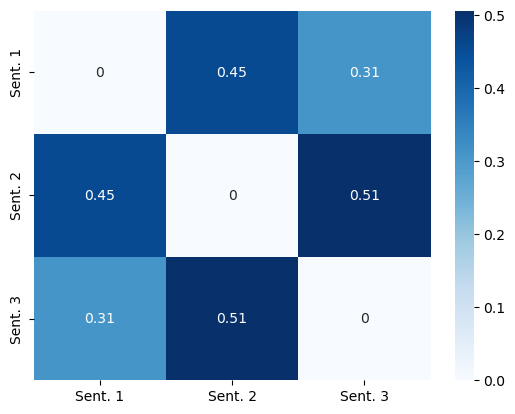

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the cosine distance between the common words in each pair of sentences
cos_11 = cosine(emb_common_1, emb_common_1)
cos_12 = cosine(emb_common_1, emb_common_2)
cos_13 = cosine(emb_common_1, emb_common_3)
cos_21 = cosine(emb_common_2, emb_common_1)
cos_22 = cosine(emb_common_2, emb_common_2)
cos_23 = cosine(emb_common_2, emb_common_3)
cos_31 = cosine(emb_common_3, emb_common_1)
cos_32 = cosine(emb_common_3, emb_common_2)
cos_33 = cosine(emb_common_3, emb_common_3)

# Store the distance values in a DataFrame for easy display
distance_matrix = pd.DataFrame({
    'Sent. 1': [cos_11, cos_21, cos_31],
    'Sent. 2': [cos_12, cos_22, cos_32],
    'Sent. 3': [cos_13, cos_23, cos_33]
})
distance_matrix.index = ['Sent. 1', 'Sent. 2', 'Sent. 3']

# Display a heatmap of the distances
sns.heatmap(distance_matrix, annot=True, cmap='Blues')
plt.show()


In [23]:
print('Sent. 1:',cos_sentence_1)
print('Sent. 2:',cos_sentence_2)
print('Sent. 3:',cos_sentence_3)

Sent. 1: Spy planes need to fly high in the sky
Sent. 2: I want to be a fly on the wall
Sent. 3: We love watching the birds when they fly above the lake


#### Observations about the distance heatmap
- The matrix is symmetrical, i.e. the distance between vectors is independent of the order in which they are considered (as expected)
- The distance between two vectors that are equal is 0 (as expected)
- The cosine between 'Fly' in sentence 1 and 2 is 0.45
- The cosine between 'Fly' in sentence 1 and 3 is 0.31 (smallest)
- The cosine between 'Fly' in sentence 2 and 3 is 0.51

In sentences 1 and 3, the _verb_ 'fly' is used but in sentence 3 'fly' is a _noun_ representing an insect. Sentence 1 and 3 have a shorter cosine distance between their version of the word 'fly' showing that it is more similar than when they are each compared to 'fly' in sentence 2.

In the code below, we look at the words 'Birds', 'They' and 'We' in sentence 3. 'We' is not defined and 'They' represent the 'Birds'. The distance `They-Birds` is 0.37 compared to 0.81 for `We-Birds`. This shows that the model understand tha the former are closely related and the latter refer to two different subjects in the context of that sentence.

In [24]:
# Isolate the embedding for the common word in each sentence
emb_we = out_1[0, tokens_3.index('We'), :].detach()
emb_birds = out_1[0, tokens_3.index('birds'), :].detach()
emb_they = out_1[0, tokens_3.index('they'), :].detach()

# Calculate the cosine
cos_birds_we = cosine(emb_birds, emb_we)
cos_birds_they = cosine(emb_birds, emb_they)

# Print the distances
print('Distance between Birds and We:', cos_birds_we)
print('Distance between Birds and They:', cos_birds_they)

Distance between Birds and We: 0.8119077086448669
Distance between Birds and They: 0.37481820583343506


### MLM = Masked Language Modeling
MLM is the pre-training objective used in BERT (in the base version of BERT, it is actually used together with NSP = next sentence prediction.)

MLM works by hiding (masking) words in a sentence and let the model predict which words, from the embedded vocabulary, are the most likely to be the right ones to fill in the blanks. Each token can be associated with a score that represents the confidence of the model for a particular word to be the right choice.

In [25]:
model_name

'bert-base-cased'

In [26]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Initialise the tokenizer and model
print('WARNINGS (can be ignored):')
mlm_tokenizer = AutoTokenizer.from_pretrained(model_name)
mlm_model = AutoModelForMaskedLM.from_pretrained(model_name)

WARNINGS (can be ignored):


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
# Assign the [MASK] token to a variable - this is done only for simplicity and readability
mask = mlm_tokenizer.mask_token

# Create a sentence with a masked word that the model will have to guess
mlm_sentence = f"I want to {mask} pizza for tonight."
print(mlm_sentence)
print(mlm_tokenizer.tokenize(mlm_sentence))

I want to [MASK] pizza for tonight.
['I', 'want', 'to', '[MASK]', 'pizza', 'for', 'tonight', '.']


In [28]:
# Tokenise and encode the sentence
encoded_inputs = mlm_tokenizer(mlm_sentence, return_tensors='pt')
outputs = mlm_model(**encoded_inputs)

# Get the logits = raw, unnormalised predictions for the token
# These are like scores for each of the tokens in the vocabulary
logits_tensor = outputs.logits

# Transform logit tensor into an array
logits = logits_tensor.detach().numpy()[0]

# Compare the number of words in the vocabulary to the dimensions
print('Vocab. size:', len(mlm_tokenizer.vocab), 'words')
print('Logits size:', logits_tensor.shape[2], 'dimensions. Shape:', logits.shape)

Vocab. size: 28996 words
Logits size: 28996 dimensions. Shape: (10, 28996)


In [29]:
# Tokens for the masked sentence
tokens = mlm_tokenizer.tokenize(mlm_sentence)

# We are only interested in the logits (scores) for the mask word
# The '+1' is used because the logit with index 0 corresponds to the [CLS] token
# i.e. the sentence actually starts at index 1 and ends at index -2. The lasy 
# index (-1) corresponds to the [SEP] token that is added for BERT.
mask_logits = logits[tokens.index(mask)+1]

In [30]:
from scipy.special import softmax
import numpy as np

# Convert the raw logits into confidence score through a softmax
confidence_scores = softmax(mask_logits)

# Sort the confidence_scores indices based on the confidence score
# Reverse the order (so it goes from max to min) and take the Top 10
# Look through the list of indices and extracts the corresponding 
# tokens (from the vaocabulary) and score (from the model output)
for tok in np.argsort(confidence_scores)[::-1][:10]:
    pred_tokens = mlm_tokenizer.decode(tok)
    score = confidence_scores[tok]

    # Print the words and their score
    print(pred_tokens, score)

# Blank line
print()

# Print the Top 3 complete sentence using the same logic
for tok in np.argsort(confidence_scores)[::-1][:3]:
    pred_tokens = mlm_tokenizer.decode(tok)
    score = confidence_scores[tok]

    # Print the words and their probability
    print(f"{mlm_sentence.replace(mask, pred_tokens.upper())} Prob.: {100*score:.1f}%")

have 0.25729188
get 0.17849575
eat 0.15555453
make 0.11422365
order 0.09823078
grab 0.052026972
buy 0.020378293
do 0.020326898
save 0.011000606
take 0.0088154785

I want to HAVE pizza for tonight. Prob.: 25.7%
I want to GET pizza for tonight. Prob.: 17.8%
I want to EAT pizza for tonight. Prob.: 15.6%
